# Supernova Signal - WFSim

Create waveform simulator instruction file based on a supernova model.

```
Created : October 2021
Last Update : 28-10-2021
Melih Kara kara@kit.edu
Ricardo Peres
```

**ToDo**<br>
Recoil spectra sampling is pretty sparse and sampling from that gives discrete values. Interpolate the final spectra and sample from that.

## Table of Contents
- None

In [1]:
# import sys
# sys.modules['admix'] = None

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import multihist as mh
import _pickle as pickle
import scipy.interpolate as itp
import click

import strax, straxen, wfsim, cutax
import nestpy
import datetime, os
from tqdm.notebook import tqdm

In [14]:
with open(r"rates_combined.pickle", "rb") as input_file:
    rates_Er, rates_t, recoil_energy_bins, timebins  = pickle.load(input_file)

In [28]:
from Supernova_Models import SN_lightcurve
from SN_plotter import Plotter
M30sn_model  = SN_lightcurve(progenitor_mass = 30,
                             metallicity= 0.02,
                             time_of_revival = 100, 
                             distance = 10)

M30sn_model.get_recoil_spectra1D()
M30sn_model.get_recoil_spectra2D()

Saving data in    data_path = '../data/'
Saving images in  img_path  = '../imgs/'
Keeping logs in   log_path  = '../logs/'

Retrieving object ../data/Object_M30-Z0.02_dist10.p
Object was found! 
To save manually: save_object(filename, update=True)

Retrieving object ../data/Object_M30-Z0.02_dist10_Er0.0-16.0_t0-0-tf-10_1D.p
Retrieving object ../data/Object_M30-Z0.02_dist10_Er0.0-15.3_step1_dist10_2D.p


In [29]:
plotter = Plotter(M30sn_model)
# fig, ax, samples = plotter.plot_sampled_energies()
# plotter.plot_sampled_energies(x='time', xscale='log');

#### Object attributes

In [17]:
# tot_rates1D = M30sn_model.total_rate1D # integrated(summed) between 0-10s 
# tot_rates2D = M30sn_model.total_rate2D
# recoil_energy_bins = M30sn_model.recoil_en
# timebins = M30sn_model.t
# nu_energies = M30sn_model.mean_E
# rates_Er, rates_t = M30sn_model._get_1Drates_from2D()
# Er_sample_E = M30sn_model.sample_from_recoil_spectrum(N_sample=100000)
# Er_sample_t = M30sn_model.sample_from_recoil_spectrum(x='time',N_sample=100000)

## dump to a pickle
# combined_dicts = [rates_Er,rates_t, recoil_energy_bins, timebins]

# with open(r"rates_combined.pickle", "wb") as output_file:
#     pickle.dump(combined_dicts, output_file)

The `sample_from_recoil_spectrum` can return 0 values, which might be a problem, as there would be no signal at these times (or worse, at negative times.)

In [18]:
def _inverse_transform_sampling( x_vals, y_vals, n_samples):
    cum_values = np.zeros(x_vals.shape)
    y_mid = (y_vals[1:]+y_vals[:-1])*0.5
    cum_values[1:] = np.cumsum(y_mid*np.diff(x_vals))
    inv_cdf = itp.interp1d(cum_values/np.max(cum_values), x_vals)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

def sample_from_recoil_spectrum(x='energy', N_sample=1):
    if x.lower()=='energy':
        spectrum = rates_Er['Total']
        xaxis = recoil_energy_bins
        ## interpolate
        intrp_rates = itp.interp1d(xaxis, spectrum, kind="cubic", fill_value="extrapolate")
        xaxis = np.linspace(xaxis.min(), xaxis.max(), 200)
        spectrum = intrp_rates(xaxis)            
    elif x.lower()=='time':
        spectrum = rates_t['Total']
        xaxis = timebins
    else: return print('choose x=time or x=energy')
    sample = _inverse_transform_sampling(xaxis, spectrum, N_sample)
    return sample

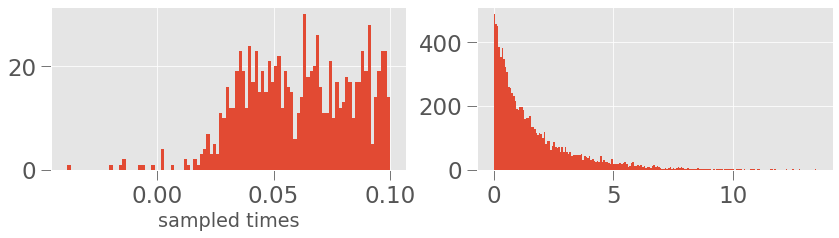

In [22]:
sample_t = sample_from_recoil_spectrum(x='time',N_sample=10000)
sample_E = sample_from_recoil_spectrum(N_sample=10000)
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,3))
ax1.hist(sample_t, range=(min(sample_t),0.1), bins=100);
ax1.set_xlabel('sampled times');
ax2.hist(sample_E, bins=200);

In [25]:
# kwargs = dict(norm=LogNorm(), bins=100) # range=[[0, 3_000], [0, 20_000]],

# mh_cut = mh.Histdd(sample_t, sample_E, **kwargs)

# mh_cut.plot(log_scale=True,
#             cblabel='count',
#             cmap=plt.get_cmap('jet'),
#             alpha=0.7,  colorbar_kwargs=dict(orientation="vertical", 
#                                              pad=0.05,
#                                              aspect=30, 
#                                              fraction=0.1));
# plt.ylabel('Recoil Energy [keV]')
# plt.xlabel('Time [s]');

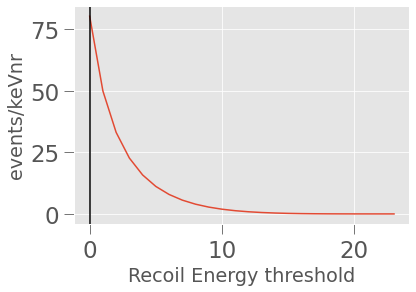

In [46]:
E_thr =  np.array([np.trapz(rates_Er['Total'][i:], recoil_energy_bins[i:]) for i,foo in enumerate(recoil_energy_bins)])

plt.plot(E_thr*4.7);
plt.ylabel('events/keVnr');
plt.xlabel('Recoil Energy threshold');
plt.axvline(0, color='k');

Take the fiducial volume as 4.7 tonnes for now. There should be ~75 events in total.

---
## Import WFSim

In [47]:
versions_str = straxen.print_versions(('strax','straxen','cutax','wfsim'), return_string=True)
straxen.print_versions(('strax','straxen','cutax','wfsim'))

Working on midway2-0418.rcc.local with the following versions and installation paths:
python	v3.8.12	(default, Oct 12 2021, 13:49:34) [GCC 7.5.0]
strax	v1.1.1	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/strax
straxen	v1.1.2	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/straxen
cutax	v0.2.2	/dali/lgrandi/xenonnt/software/cutax/latest/cutax
wfsim	v0.5.9	/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.8/site-packages/wfsim


In [48]:
# wfsim.instruction_dtype

Based on nest's naming convention [here](https://github.com/XENONnT/WFSim/blob/2c614b0f7b0d7c7adc516f6188e281857e8d7e22/wfsim/core.py#L22)

Ricardo's script for instruction generation https://github.com/XENONnT/analysiscode/blob/master/S2_shape_width/simulation/make_submit_files.py

In [49]:
volume = 4.7

In [139]:
def instructions_SNdata_magnificient(nevents, interaction_type=0, 
                                     dump_csv=False, filename=None,
                                     below_cathode=False):
    ''' WFsim instructions to simulate Supernova NR peak.
        Parameters
        ----------
        nevents : `int`
            total number of events desired
            
        Notes
        -----
        For each SN signal there is E_thr[0]*volume events generated
        to generate nevents we shift times nevents/(number of single SN events)
        
    '''
    n = nevents
    A, Z  = 131.293, 54
    lxe_density = 2.862 #g/cm^3
    drift_field = 18.3 #V/cm
    
    number_of_events = np.ceil(E_thr[0]*volume).astype(int)
    nr_iterations = np.ceil(n/number_of_events).astype(int)
    rolled_sample_size = int(nr_iterations*number_of_events)
    n = rolled_sample_size
    sample_E = np.ones(rolled_sample_size)*-1
    sample_t = np.ones(rolled_sample_size)*-1
    ## shifted time sampling
    for i in range(nr_iterations):
        from_ = int(i*number_of_events)
        to_ = int((i+1)*number_of_events)
        time_shift = i*20 # add 20 sec to each iteration
        sample_E[from_:to_] = sample_from_recoil_spectrum(N_sample=number_of_events)
        sample_t[from_:to_] = sample_from_recoil_spectrum(x='time',N_sample=number_of_events) + time_shift
        
        # SN signal also has pre-SN neutrino, so if there are negative times boost them
        minnum = np.min(sample_t)
        if minnum <= 0: sample_t -= minnum      
            
    instructions = np.ones(2*n, dtype = wfsim.instruction_dtype)
    instructions[:] = -1
    instructions['time'] = (1e8 * sample_t).repeat(2)+1000000
    
    instructions['event_number'] = np.arange(0, n).repeat(2)
    instructions['type'] = np.tile([1,2], n)
    instructions['recoil'][:] = interaction_type
    instructions['local_field'][:] = 18
    
    r = np.sqrt(np.random.uniform(0, straxen.tpc_r**2, n)) 
    t = np.random.uniform(-np.pi, np.pi, n)
    instructions['x'] = np.repeat(r * np.cos(t), 2)
    instructions['y'] = np.repeat(r * np.sin(t), 2)
    if below_cathode:
        instructions['z'] = np.repeat(np.random.uniform(-straxen.tpc_z-12, 0, n), 2)
    else:
        instructions['z'] = np.repeat(np.random.uniform(-straxen.tpc_z, 0, n), 2)
    
    interaction_type = nestpy.INTERACTION_TYPE(interaction_type)    
    nc = nestpy.nestpy.NESTcalc(nestpy.nestpy.VDetector())
    
    quanta, exciton, recoil, e_dep = [], [], [], []
    for energy_deposit in tqdm(sample_E, desc='generating instructions from nest'):
        interaction = nestpy.INTERACTION_TYPE(interaction_type)
        y = nc.GetYields(interaction, energy_deposit, lxe_density, drift_field, A, Z)
        q = nc.GetQuanta(y, lxe_density)
        quanta.append(q.photons)
        quanta.append(q.electrons)
        exciton.append(q.excitons)
        exciton.append(0)
        # both S1 and S2
        recoil += [interaction_type, interaction_type]
        e_dep += [energy_deposit, energy_deposit]

    instructions['amp'] = quanta
    instructions['local_field'] = drift_field
    instructions['n_excitons'] = exciton
    instructions['recoil'] = recoil
    instructions['e_dep'] = e_dep
    instructions_df = pd.DataFrame(instructions)
    instructions_df = instructions_df[instructions_df['amp'] > 0]
    instructions_df.sort_values('time', inplace=True)
    if dump_csv:
        tdy = str(datetime.date.today())
        filename = filename or f'{tdy}_instructions.csv'
        instructions_df.to_csv(f'/dali/lgrandi/melih/sn_wfsim/instructions/{filename}', index=False)
        print(f'Saved in -> /dali/lgrandi/melih/sn_wfsim/instructions/{filename}')
    return instructions_df

In [178]:
a = instructions_SNdata_magnificient(10000, dump_csv=True, filename='SN_wfsim_instructions.csv')
b = instructions_SNdata_magnificient(100000, dump_csv=True, filename='SN_wfsim_instructions_100k.csv')

generating instructions from nest:   0%|          | 0/10044 [00:00<?, ?it/s]


CAUTION: You are approaching the border of NEST's validity for high-energy (OR, for LOW) NR, or are beyond it, at 2.01278e-06 keV.


Saved in -> /dali/lgrandi/melih/sn_wfsim/instructions/SN_wfsim_instructions.csv


generating instructions from nest:   0%|          | 0/100035 [00:00<?, ?it/s]

Saved in -> /dali/lgrandi/melih/sn_wfsim/instructions/SN_wfsim_instructions_100k.csv


In [182]:
# plt.hist(a['time']);
# plt.hist(a['e_dep']);

In [236]:
def clean_repos(pattern='*'):
    if input('Are you sure to delete all the data?\n'
            '\t/dali/lgrandi/melih/sn_wfsim/instructions/*\n'
            '\t/dali/lgrandi/melih/sn_wfsim/logs/*\n'
            '\t/dali/lgrandi/melih/sn_wfsim/strax_data/*\n>>>').lower() == 'y':
        os.system(f'rm -r /dali/lgrandi/melih/sn_wfsim/instructions/{pattern}')
        os.system(f'rm -r /dali/lgrandi/melih/sn_wfsim/logs/{pattern}')
        os.system(f'rm -r /dali/lgrandi/melih/sn_wfsim/strax_data/{pattern}')
        
def see_repos():
    if not os.path.isdir('/dali/lgrandi/melih/sn_wfsim/logs/'):
        os.mkdir('/dali/lgrandi/melih/sn_wfsim/logs/')
    if not os.path.isdir('/dali/lgrandi/melih/sn_wfsim/strax_data/'):
        os.mkdir('/dali/lgrandi/melih/sn_wfsim/strax_data/')
    click.secho('\n >>Instructions\n', bg='blue', color='white');    os.system(f'ls -r /dali/lgrandi/melih/sn_wfsim/instructions/')
    click.secho('\n >>Logs\n', bg='blue', color='white');            os.system(f'ls -r /dali/lgrandi/melih/sn_wfsim/logs/')
    click.secho('\n >>Existing data\n', bg='blue', color='white');   os.system(f'ls -r /dali/lgrandi/melih/sn_wfsim/strax_data/')

In [255]:
# clean_repos()
see_repos()


 >>Instructions

SN_wfsim_instructions_100k.csv
SN_wfsim_instructions.csv

 >>Logs

wfsim_high-stat.out
wfsim_high-stat.err

 >>Existing data

SN_wfsimdata_100k-truth-my4gxfhotd_temp
SN_wfsimdata_100k-raw_records_he-my4gxfhotd_temp
SN_wfsimdata_100k-raw_records_aqmon-my4gxfhotd_temp
SN_wfsimdata_100k-raw_records-my4gxfhotd_temp
SN_wfsimdata-truth-my4gxfhotd
SN_wfsimdata-raw_records_he-my4gxfhotd
SN_wfsimdata-raw_records_aqmon-my4gxfhotd
SN_wfsimdata-raw_records-my4gxfhotd
SN_wfsimdata-peaklets-bie4dbe7uq
SN_wfsimdata-peaklet_classification-zx5hnlbcxi
SN_wfsimdata-peak_proximity-ms2awbcenc
SN_wfsimdata-peak_positions_mlp-trboz276tl
SN_wfsimdata-peak_positions_gcn-kjccspojaq
SN_wfsimdata-peak_positions_cnn-gzc3ptv4wd
SN_wfsimdata-peak_basics-qx25yaesdk
SN_wfsimdata-merged_s2s-wb6turax6q
SN_wfsimdata-lone_hits-bie4dbe7uq
SN_wfsimdata-event_positions-4fnlquguxu
SN_wfsimdata-event_info-b2pyr5zdyi
SN_wfsimdata-event_basics-cuklgxp2na
SN_wfsimdata-corrected_areas-i4vm62cwbg


In [254]:
st = cutax.contexts.xenonnt_sim_SR0v0_cmt_v5(output_folder='/dali/lgrandi/melih/sn_wfsim/strax_data')
st.set_config(dict(fax_config_override=dict(field_distortion_on=False)))
rid = 'SN_wfsimdata'
for kind in ['truth', 'raw_records', 'peaks']:
    click.echo(f'{kind:15s} is {click.style(" stored ", bold=True, bg="green") if st.is_stored(rid, kind) else click.style(" not stored ",bold=True,bg="red")}')

truth           is  stored 
raw_records     is  stored 
peaks           is  not stored 


In [154]:
df = st.get_df(rid,'event_info')
truth = st.get_df(rid,'truth')
peak_basics = st.get_df(rid, 'peak_basics')
event_info = st.get_df(rid, 'event_info')

Loading event_info: |          | 0.00 % [00:00<?]

Loading truth: |          | 0.00 % [00:00<?]

Loading peak_basics: |          | 0.00 % [00:00<?]

Loading event_info: |          | 0.00 % [00:00<?]

In [229]:
def quality_plot(ev):
    plt.figure(figsize=(15,10))
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.subplot(321); plt.title('s1 area')
    plt.hist(ev['s1_area'], bins = 200, histtype = 'step')
    
    plt.subplot(322); plt.title('s2 area')
    plt.hist(ev['s2_area'], bins = 200, histtype = 'step')
    
    plt.subplot(323); plt.title('s2 width')
    plt.hist(ev['s2_range_50p_area'], bins = 200, histtype = 'step')
    
    plt.subplot(324); plt.title('counts above area threshold') #plt.title('dt [us]')
#     plt.hist(ev['drift_time']/1000, bins = 200, histtype = 'step')
    counts_above_i = []
    s2range = np.linspace(ev['s2_area'].min(), 1500, 50)
    for i, thr in enumerate(s2range):
        counts_above_i.append(len(ev['s2_area'][ev['s2_area']>thr]))
    plt.semilogy(s2range, counts_above_i)
    plt.xlabel('S2 area')

    plt.subplot(325); plt.title('z [cm]')
    plt.hist(ev['z'][ev['z']<0], bins = 200, histtype = 'step')
    plt.axvline(-straxen.tpc_z, ls = '--', color = 'k')
    
    plt.subplot(326);
    plt.gca().set_aspect('equal')
    s1 = ev['s1_area']
    s2 = ev['s2_area']
    mask = (s1>0) & (s2>0) 
    kwargs = dict(norm=LogNorm(), bins=100) # range=[[0, 3_000], [0, 20_000]],
    mh_cut = mh.Histdd(s1[mask], s2[mask]/100, **kwargs)
    mh_cut.plot(log_scale=True, cblabel='count',
            cmap=plt.get_cmap('jet'), alpha=0.7,  
            colorbar_kwargs=dict(orientation="vertical", 
                                 pad=0.05,
                                 aspect=30, 
                                 fraction=0.1));
    plt.xlabel('s1 area [P.E.]'); plt.ylabel('s2 area [100 P.E.]');
    
def plot_xy_rz(evt):
    plt.figure(figsize=(12,4))
    plt.subplots_adjust(wspace=0.9)
    plt.subplot(121)
    plt.hist2d(evt['x'],evt['y'], range = ((-70,70),(-70,70)),cmin = 1,bins = 100) # , norm = LogNorm()
    plt.xlabel('x [cm]')
    plt.ylabel('y [cm]')
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.subplot(122)
    plt.hist2d(np.power(evt['r'],2),evt['z'], range = ((0,70**2),(-160,10)),cmin = 1,bins = 100) # , norm = LogNorm()
    plt.colorbar()
    plt.xlabel('r$^2$ [cm]')
    plt.ylabel('z [cm]')
    plt.show()

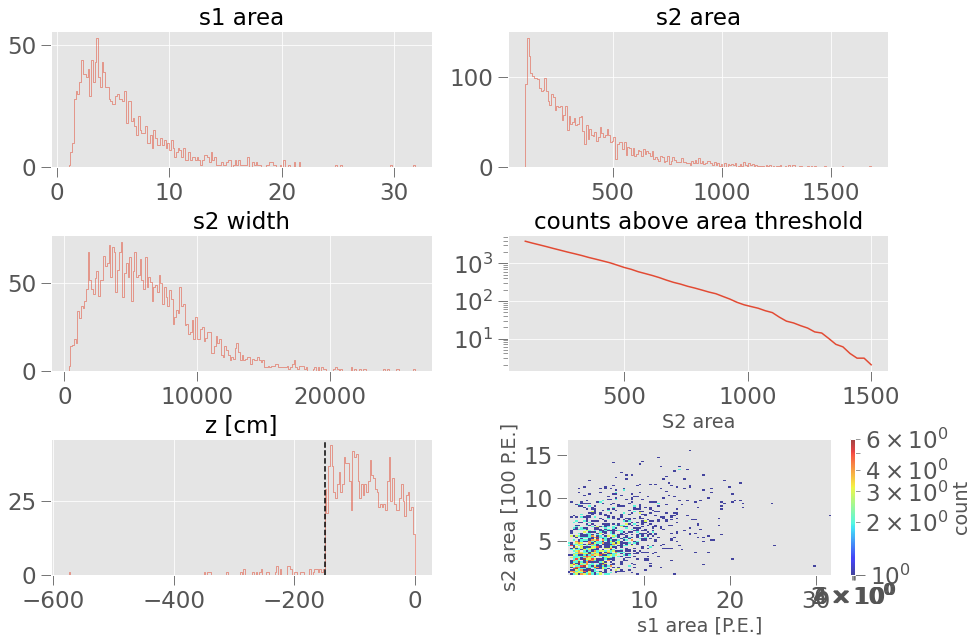

In [197]:
quality_plot(event_info)

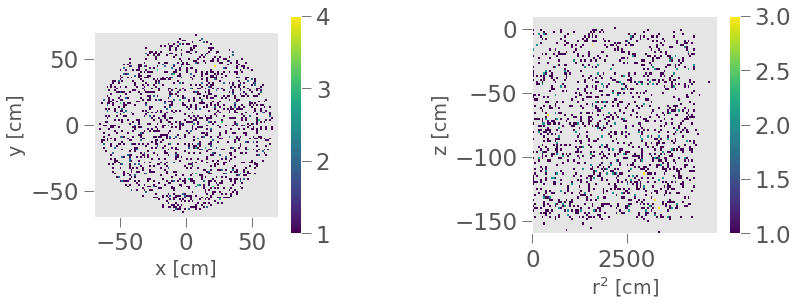

In [230]:
plot_xy_rz(event_info)

In [199]:
st.data_info('event_info')['Field name'].values

array(['time', 'endtime', 'cs1', 'cs2_wo_elifecorr',
       'cs2_area_fraction_top', 'cs2_bottom', 'cs2', 'alt_cs1',
       'alt_cs2_wo_elifecorr', 'alt_cs2_area_fraction_top',
       'alt_cs2_bottom', 'alt_cs2', 'e_light', 'e_charge', 'e_ces',
       'n_peaks', 'drift_time', 'event_number', 's1_index',
       'alt_s1_index', 's1_time', 'alt_s1_time', 's1_center_time',
       'alt_s1_center_time', 's1_endtime', 'alt_s1_endtime', 's1_area',
       'alt_s1_area', 's1_n_channels', 'alt_s1_n_channels',
       's1_n_competing', 'alt_s1_n_competing', 's1_max_pmt',
       'alt_s1_max_pmt', 's1_max_pmt_area', 'alt_s1_max_pmt_area',
       's1_range_50p_area', 'alt_s1_range_50p_area', 's1_range_90p_area',
       'alt_s1_range_90p_area', 's1_rise_time', 'alt_s1_rise_time',
       's1_area_fraction_top', 'alt_s1_area_fraction_top',
       's1_tight_coincidence', 'alt_s1_tight_coincidence',
       's1_n_saturated_channels', 'alt_s1_n_saturated_channels',
       's1_tight_coincidence_channel', 'alt

In [172]:
len(a['z']), len(truth['z']), len(event_info['z']), len(event_info['z_naive']), peak_basics

(16133, 13084, 3899, 3899)

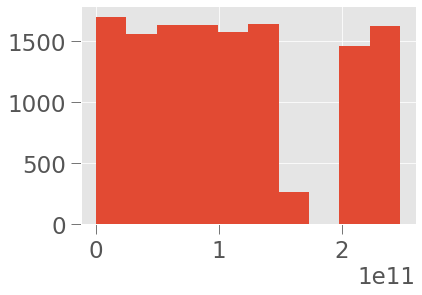

In [224]:
plt.hist(truth['time']);

---